In [7]:
## importing required libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from numpy.random import randn
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [8]:
## reading csv file and printing its shape , last indexes data and all cloumns
data = pd.read_csv('diabetes.csv')
print (data.shape)
print (data.tail())
print (data.columns)

(768, 9)
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [9]:
## out of given columns our target will be 'OUTCOME' so labelling it as Y and other as X
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

label = ['Outcome']
X = data[features]
y = data[label]

In [10]:
## Train and test splitting 
X_true_train, X_true_test, y_true_train, y_true_test = train_test_split(X, y, test_size=0.30, random_state=42)


# Since our dataset is a binary classification dataset so we will apply :Random forest,svm and decision tree and will take that model which have higher accuracy 

In [11]:
## random forest
clf_true = RandomForestClassifier(n_estimators=500)
clf_true.fit(X_true_train,y_true_train)

y_true_pred=clf_true.predict(X_true_test)
print("Base Accuracy:",metrics.accuracy_score(y_true_test, y_true_pred))

<ipython-input-11-389e32a95469>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_true.fit(X_true_train,y_true_train)


Base Accuracy: 0.7619047619047619


In [12]:
## Decision Tree
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_true_train, y_true_train)
predictions = dtree.predict(X_true_test)
print("Accuracy Score =", format(metrics.accuracy_score(y_true_test,predictions)))

Accuracy Score = 0.7186147186147186


In [13]:
## Support Vector Machine (SVM)
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_true_train, y_true_train)
svc_pred = svc_model.predict(X_true_test)
print("Accuracy Score =", format(metrics.accuracy_score(y_true_test, svc_pred)))


Accuracy Score = 0.7359307359307359


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Conclusion- Random forest having highest accuracy which is about 76.19%

# Now our task is to generate synthetic data and compare base accuracy with accuracy of generated data using random forest and will play with generator and discriminator to get the desired results.

In [15]:
## generating synthetic data
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [16]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    
    return X, y

In [17]:
# generate n real samples with class labels; We randomly select n samples from the real data
def generate_real_samples(n):
    X = data.sample(n)
    y = np.ones((n, 1))
    return X, y

In [183]:
def define_generator(latent_dim, n_outputs=9):
    model = Sequential()
    model.add(Dense(15, activation='relu',  kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(n_outputs, activation='linear'))
    return model

In [184]:
generator1 = define_generator(10, 9)
generator1.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_122 (Dense)           (None, 15)                165       
                                                                 
 dense_123 (Dense)           (None, 30)                480       
                                                                 
 dense_124 (Dense)           (None, 9)                 279       
                                                                 
Total params: 924
Trainable params: 924
Non-trainable params: 0
_________________________________________________________________


In [197]:
def define_discriminator(n_inputs=9):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [198]:
discriminator1 = define_discriminator(9)
discriminator1.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_138 (Dense)           (None, 25)                250       
                                                                 
 dense_139 (Dense)           (None, 50)                1300      
                                                                 
 dense_140 (Dense)           (None, 1)                 51        
                                                                 
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________


In [199]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [200]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist):
    # plot loss
    plt.subplot(1, 1, 1)
    plt.plot(d_hist, label='d')
    plt.plot(g_hist, label='gen')
    plt.show()
    plt.close()

In [202]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=100, n_batch=128):
  # determine half the size of one batch, for updating the  discriminator
  half_batch = int(n_batch / 2)
  d_history = []
  g_history = []
  # manually enumerate epochs
  for epoch in range(n_epochs):
    
    # prepare real samples
    x_real, y_real = generate_real_samples(half_batch)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator
    d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
    d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = np.ones((n_batch, 1))
    # update the generator via the discriminator's error
    g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)
    print('>%d, d1=%.3f, d2=%.3f d=%.3f g=%.3f' % (epoch+1, d_loss_real, d_loss_fake, d_loss,  g_loss_fake))
    d_history.append(d_loss)
    g_history.append(g_loss_fake)
    plot_history(d_history, g_history)
    g_model.save('trained_generated_model.h5')

2/2 [==============================] - 0s 4ms/step
>1, d1=0.000, d2=0.750 d=0.375 g=0.669


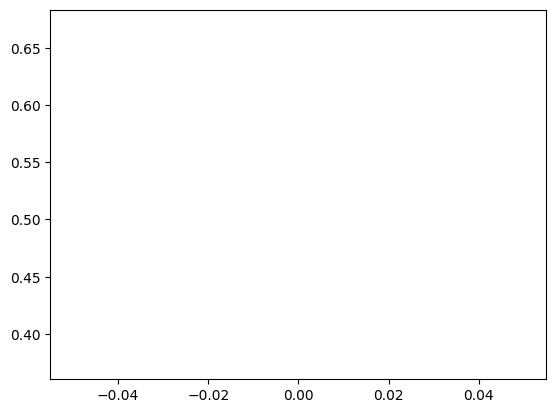

2/2 [==============================] - 0s 4ms/step
>2, d1=0.000, d2=0.778 d=0.389 g=0.667


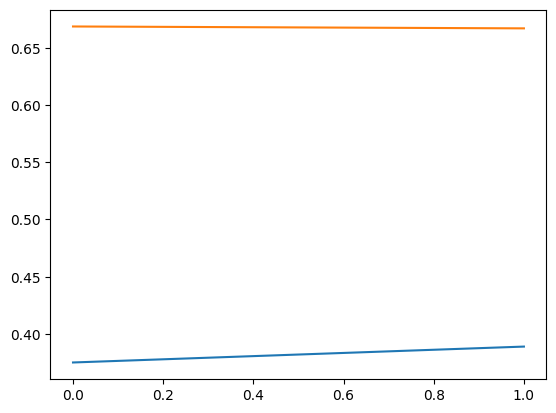

2/2 [==============================] - 0s 6ms/step
>3, d1=0.000, d2=0.721 d=0.361 g=0.696


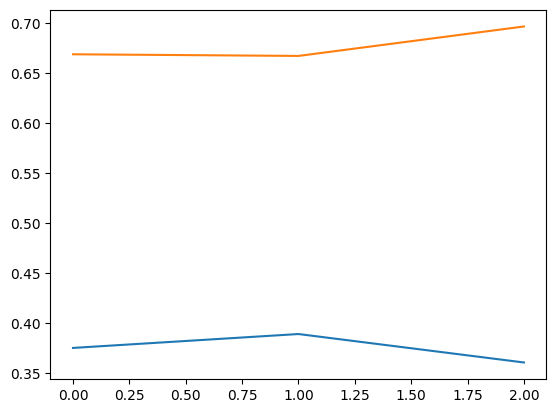

2/2 [==============================] - 0s 4ms/step
>4, d1=0.335, d2=0.737 d=0.536 g=0.708


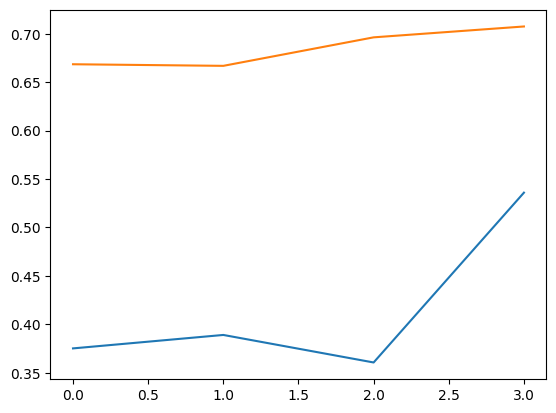

2/2 [==============================] - 0s 6ms/step
>5, d1=0.124, d2=0.709 d=0.417 g=0.686


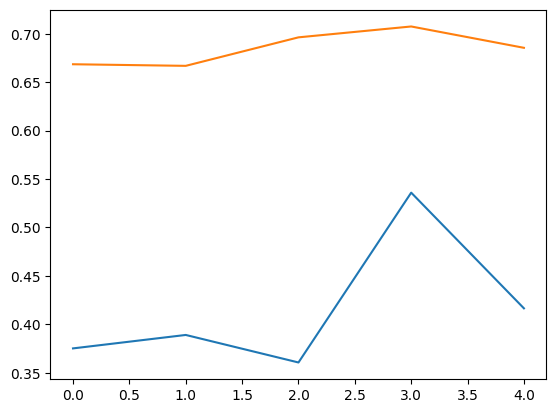

2/2 [==============================] - 0s 5ms/step
>6, d1=0.000, d2=0.719 d=0.360 g=0.685


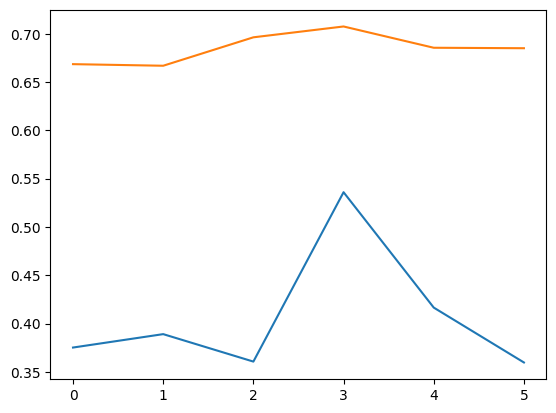

2/2 [==============================] - 0s 5ms/step
>7, d1=0.000, d2=0.690 d=0.345 g=0.679


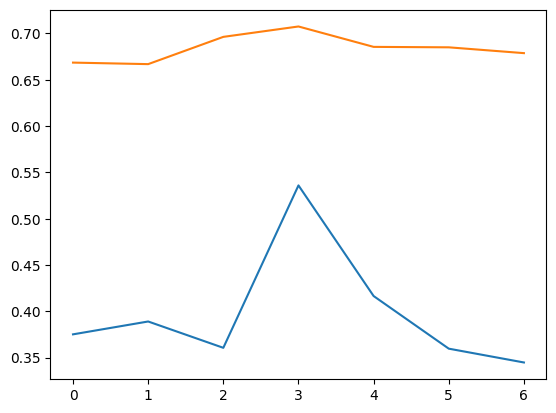

2/2 [==============================] - 0s 4ms/step
>8, d1=0.000, d2=0.703 d=0.352 g=0.719


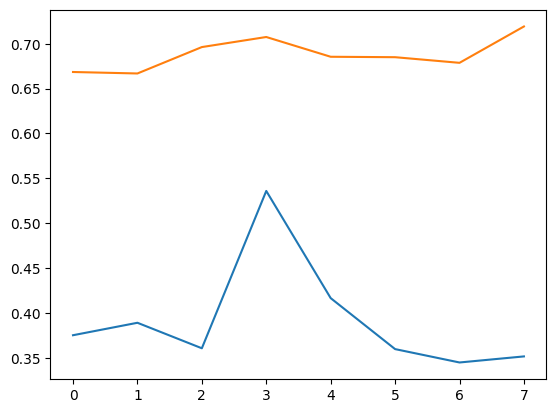

2/2 [==============================] - 0s 4ms/step
>9, d1=0.000, d2=0.752 d=0.376 g=0.707


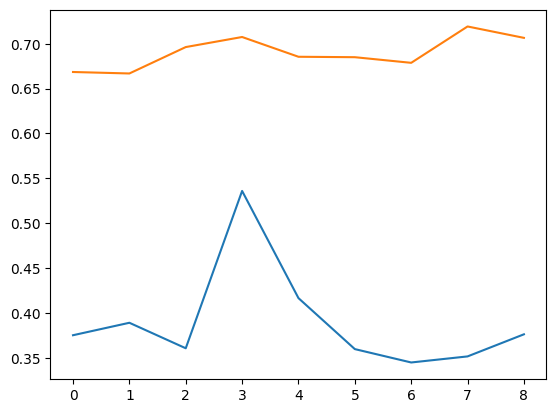

2/2 [==============================] - 0s 7ms/step
>10, d1=0.000, d2=0.702 d=0.351 g=0.700


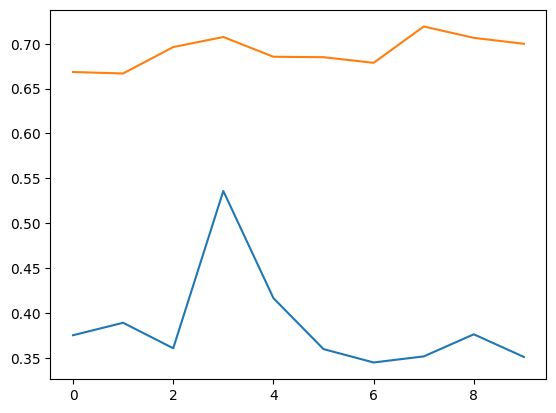

2/2 [==============================] - 0s 8ms/step
>11, d1=0.000, d2=0.682 d=0.341 g=0.701


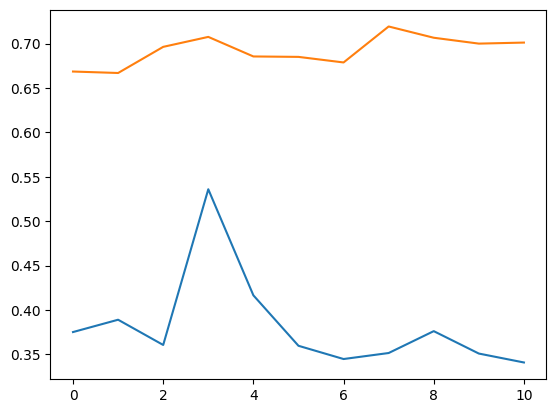

2/2 [==============================] - 0s 5ms/step
>12, d1=0.000, d2=0.699 d=0.350 g=0.735


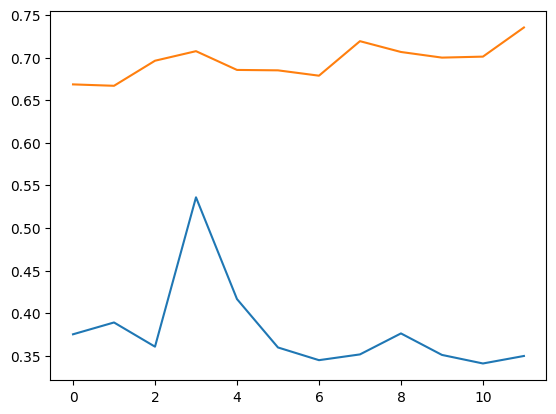

2/2 [==============================] - 0s 7ms/step
>13, d1=0.000, d2=0.647 d=0.324 g=0.725


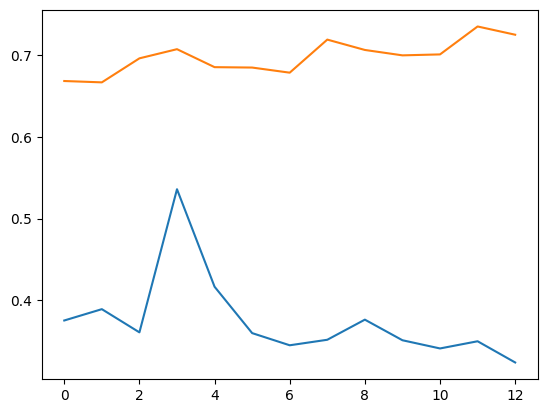

2/2 [==============================] - 0s 3ms/step
>14, d1=0.000, d2=0.667 d=0.333 g=0.757


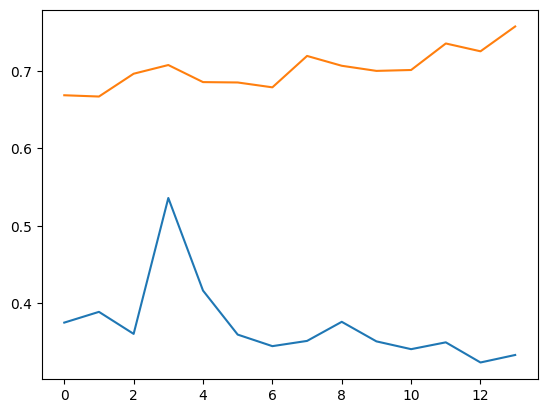

2/2 [==============================] - 0s 5ms/step
>15, d1=0.000, d2=0.639 d=0.320 g=0.775


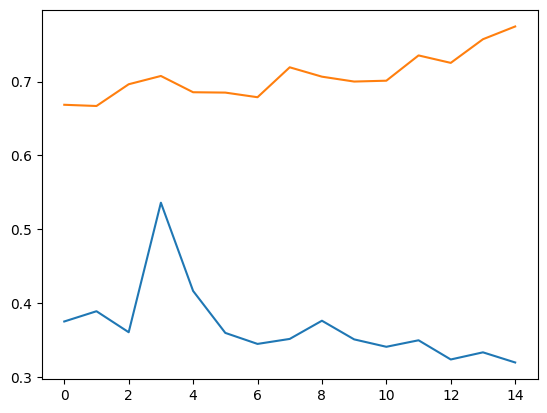

2/2 [==============================] - 0s 4ms/step
>16, d1=0.000, d2=0.640 d=0.320 g=0.791


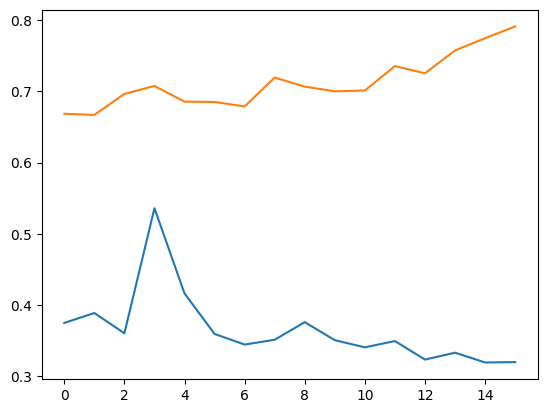

2/2 [==============================] - 0s 6ms/step
>17, d1=0.010, d2=0.641 d=0.325 g=0.781


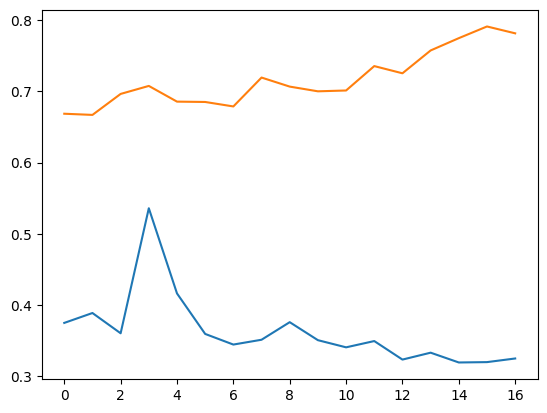

2/2 [==============================] - 0s 6ms/step
>18, d1=0.000, d2=0.613 d=0.306 g=0.792


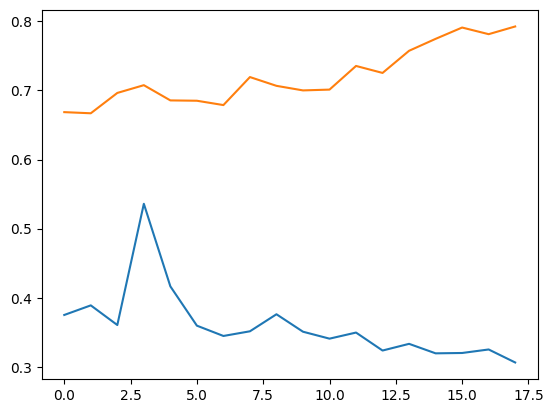

2/2 [==============================] - 0s 7ms/step
>19, d1=0.000, d2=0.613 d=0.307 g=0.795


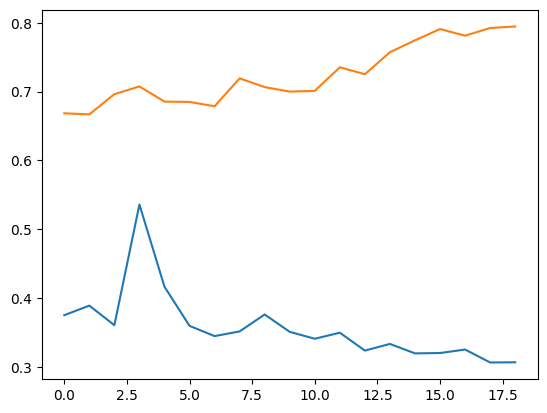

2/2 [==============================] - 0s 6ms/step
>20, d1=0.000, d2=0.611 d=0.306 g=0.799


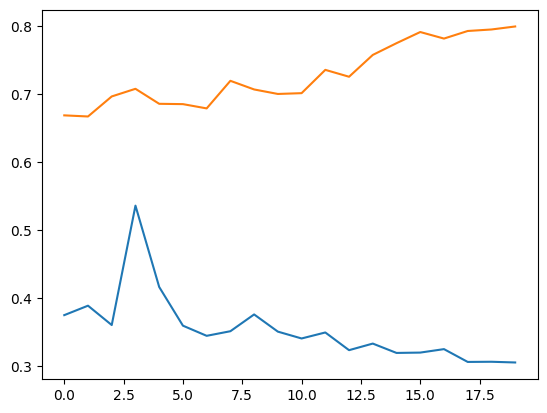

2/2 [==============================] - 0s 6ms/step
>21, d1=0.001, d2=0.584 d=0.292 g=0.815


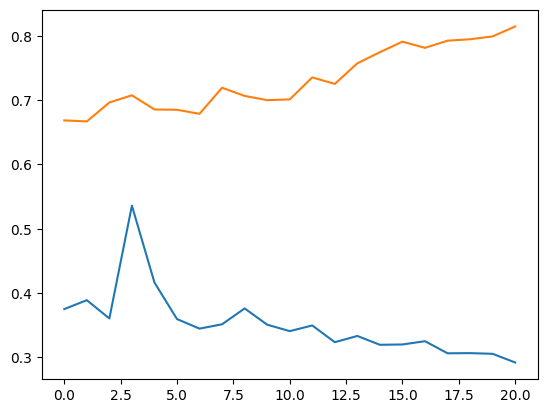

2/2 [==============================] - 0s 10ms/step
>22, d1=0.001, d2=0.608 d=0.305 g=0.829


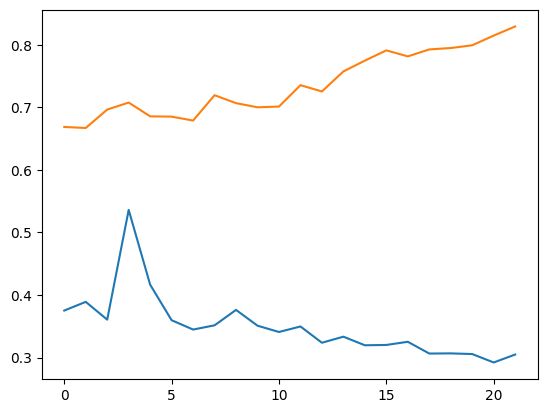

2/2 [==============================] - 0s 4ms/step
>23, d1=0.158, d2=0.583 d=0.370 g=0.815


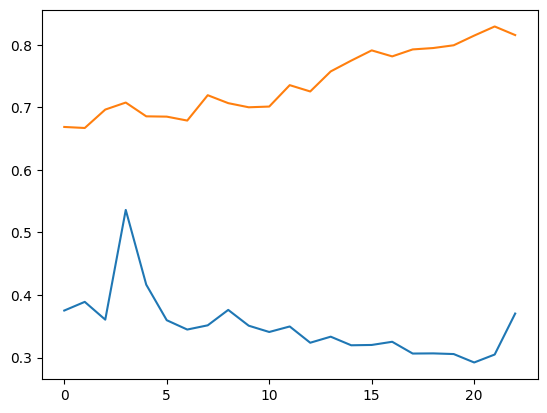

2/2 [==============================] - 0s 7ms/step
>24, d1=0.010, d2=0.603 d=0.307 g=0.812


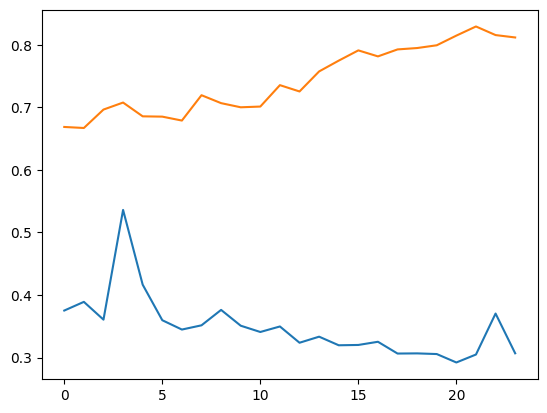

2/2 [==============================] - 0s 6ms/step
>25, d1=0.044, d2=0.604 d=0.324 g=0.807


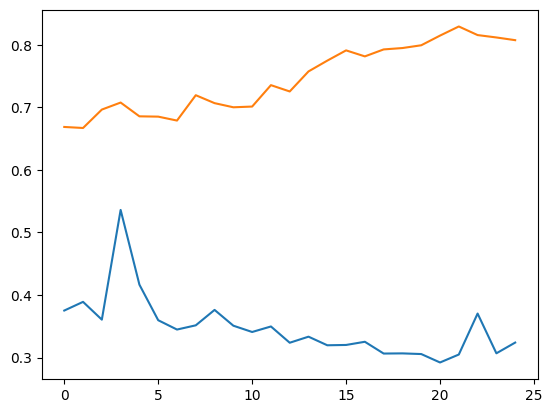

2/2 [==============================] - 0s 3ms/step
>26, d1=0.003, d2=0.586 d=0.294 g=0.802


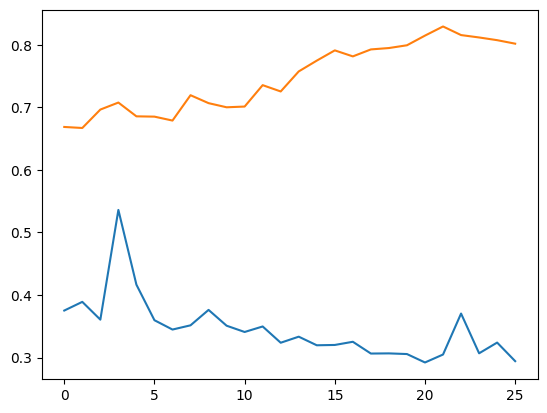

2/2 [==============================] - 0s 4ms/step
>27, d1=0.002, d2=0.611 d=0.307 g=0.786


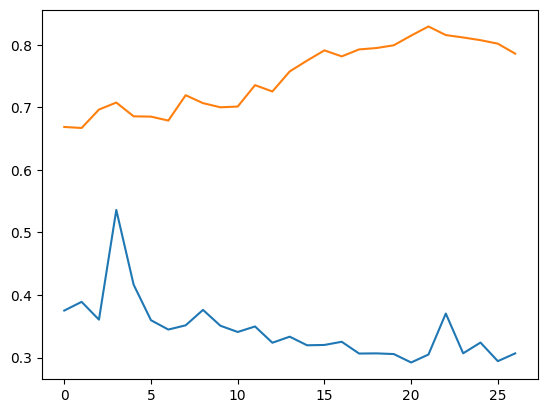

2/2 [==============================] - 0s 3ms/step
>28, d1=0.001, d2=0.639 d=0.320 g=0.779


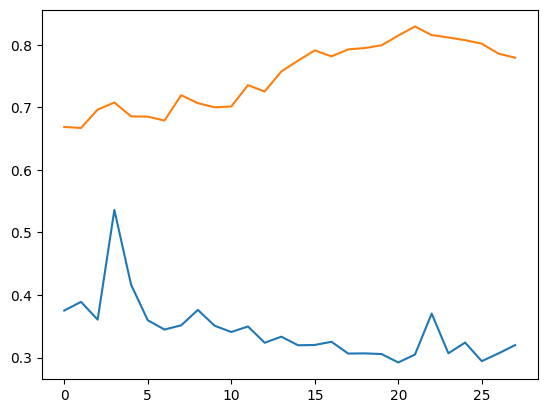

2/2 [==============================] - 0s 6ms/step
>29, d1=0.002, d2=0.599 d=0.301 g=0.780


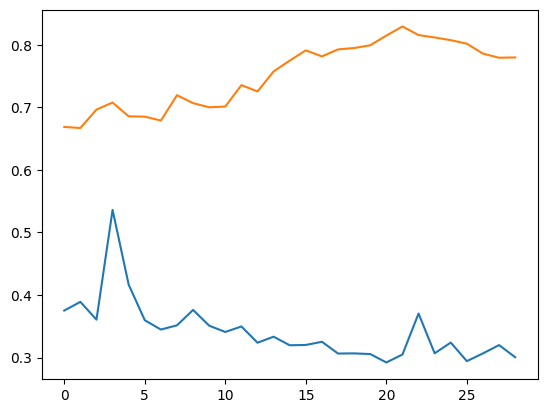

2/2 [==============================] - 0s 5ms/step
>30, d1=0.010, d2=0.642 d=0.326 g=0.778


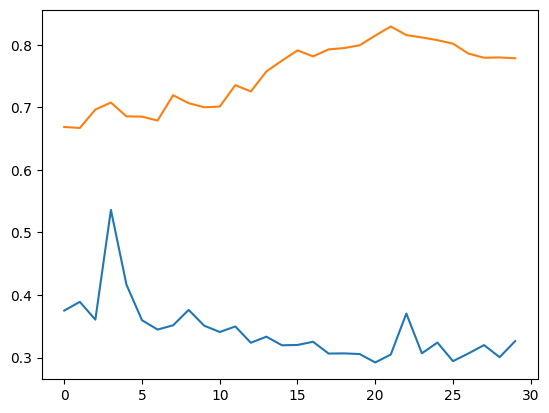

2/2 [==============================] - 0s 6ms/step
>31, d1=0.001, d2=0.649 d=0.325 g=0.770


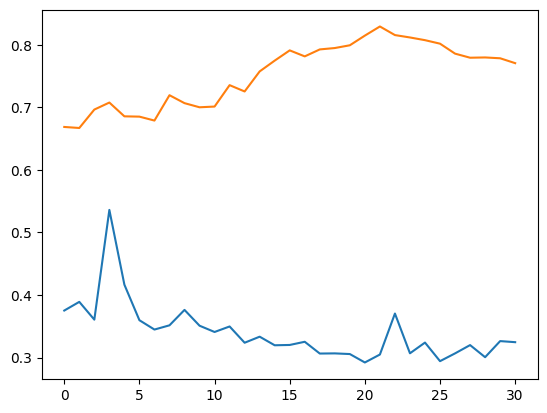

2/2 [==============================] - 0s 4ms/step
>32, d1=0.001, d2=0.628 d=0.315 g=0.774


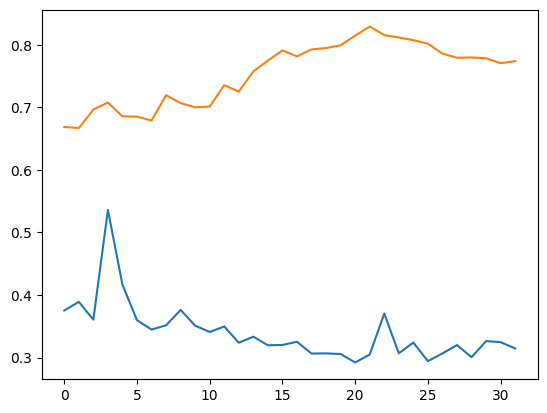

2/2 [==============================] - 0s 5ms/step
>33, d1=0.001, d2=0.647 d=0.324 g=0.791


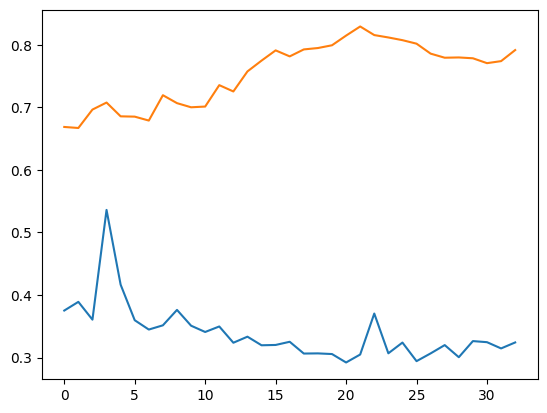

2/2 [==============================] - 0s 4ms/step
>34, d1=0.000, d2=0.619 d=0.310 g=0.786


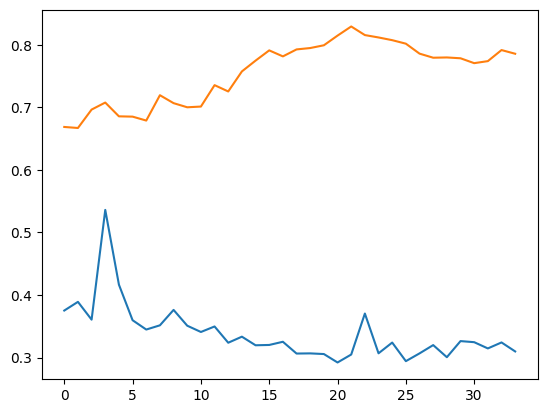

2/2 [==============================] - 0s 10ms/step
>35, d1=0.001, d2=0.623 d=0.312 g=0.786


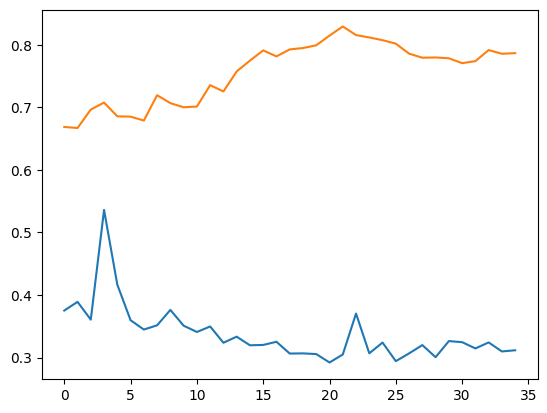

2/2 [==============================] - 0s 4ms/step
>36, d1=0.231, d2=0.627 d=0.429 g=0.792


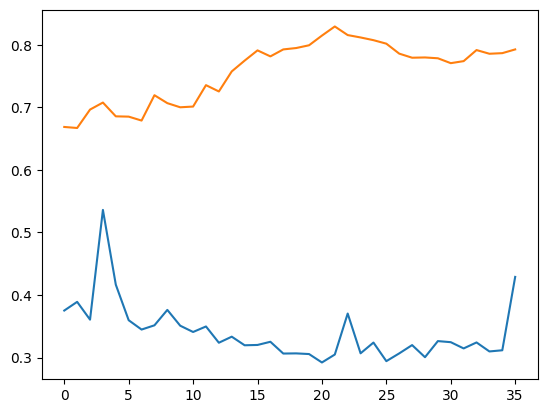

2/2 [==============================] - 0s 4ms/step
>37, d1=0.001, d2=0.618 d=0.310 g=0.793


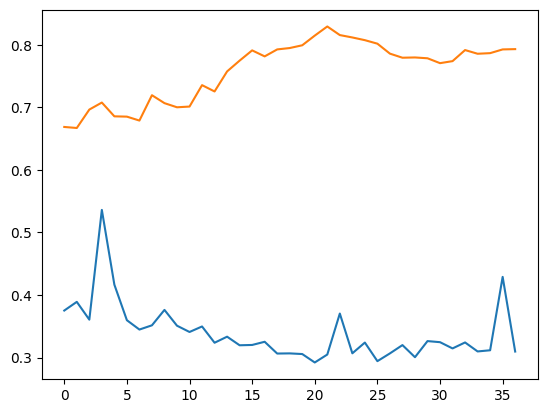

2/2 [==============================] - 0s 4ms/step
>38, d1=0.019, d2=0.631 d=0.325 g=0.787


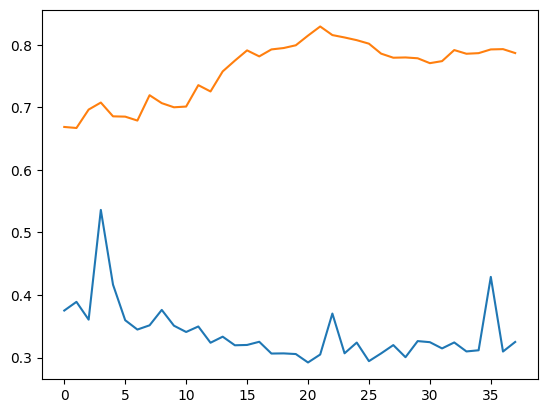

2/2 [==============================] - 0s 4ms/step
>39, d1=0.227, d2=0.624 d=0.425 g=0.777


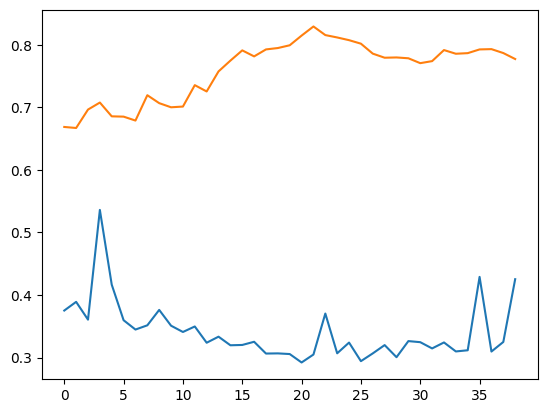

2/2 [==============================] - 0s 4ms/step
>40, d1=0.001, d2=0.625 d=0.313 g=0.773


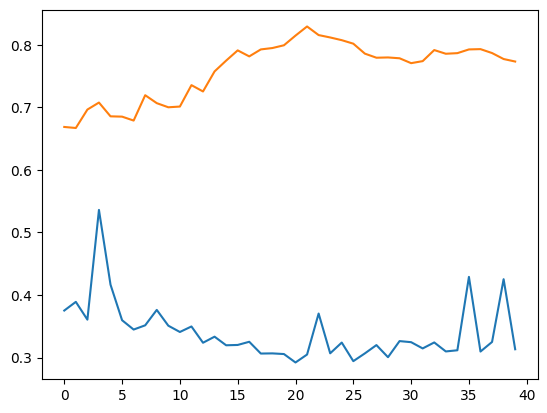

2/2 [==============================] - 0s 4ms/step
>41, d1=0.003, d2=0.611 d=0.307 g=0.785


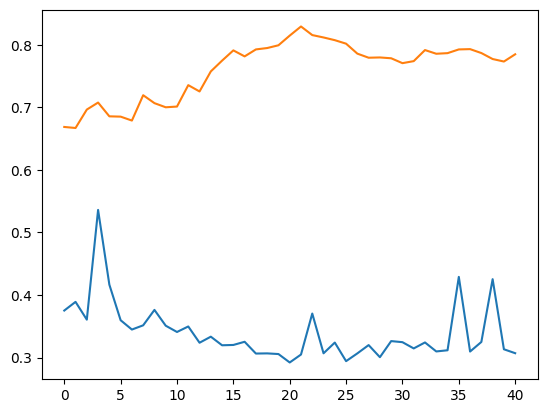

2/2 [==============================] - 0s 8ms/step
>42, d1=0.004, d2=0.624 d=0.314 g=0.792


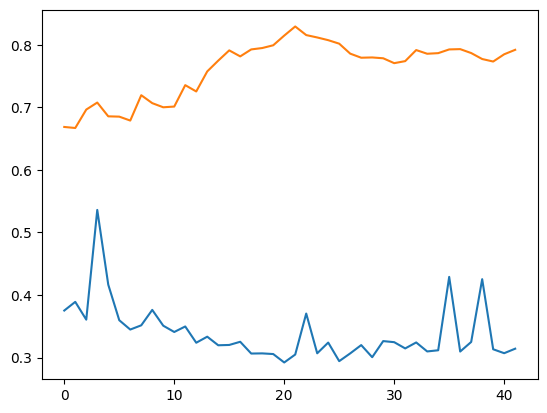

2/2 [==============================] - 0s 5ms/step
>43, d1=0.004, d2=0.618 d=0.311 g=0.782


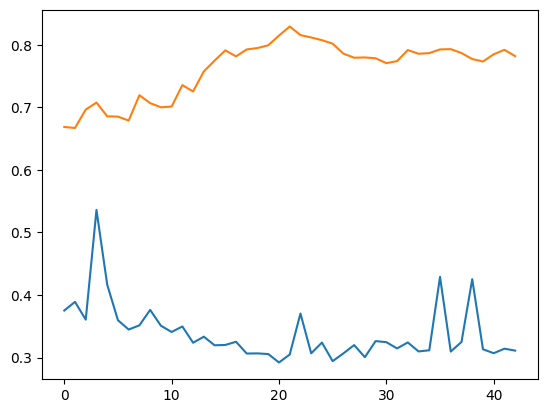

2/2 [==============================] - 0s 5ms/step
>44, d1=0.006, d2=0.610 d=0.308 g=0.774


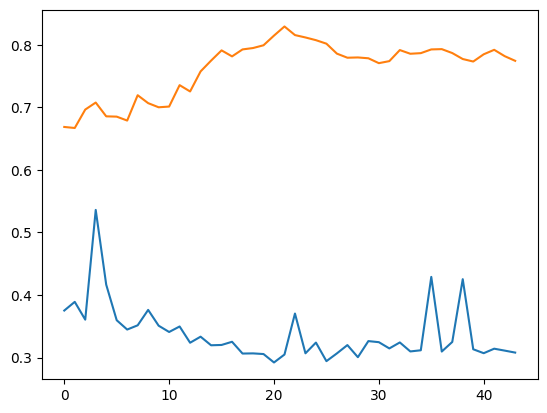

2/2 [==============================] - 0s 4ms/step
>45, d1=0.083, d2=0.616 d=0.350 g=0.789


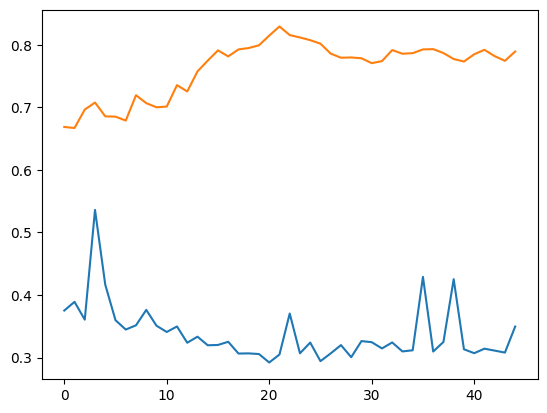

2/2 [==============================] - 0s 4ms/step
>46, d1=0.010, d2=0.606 d=0.308 g=0.797


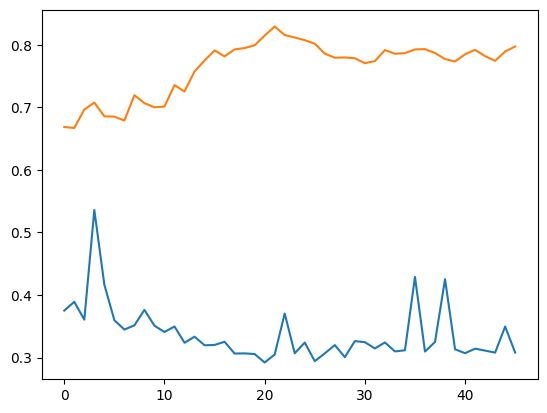

2/2 [==============================] - 0s 12ms/step
>47, d1=0.003, d2=0.616 d=0.310 g=0.787


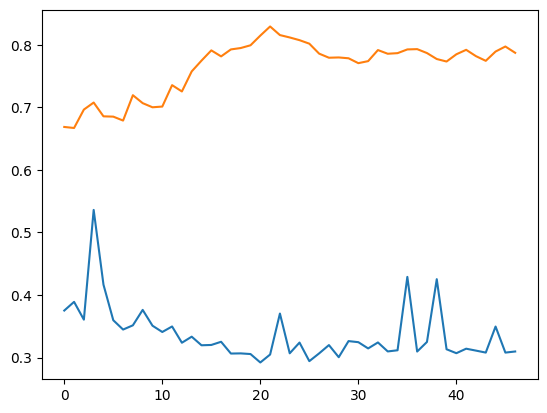

2/2 [==============================] - 0s 4ms/step
>48, d1=0.009, d2=0.607 d=0.308 g=0.790


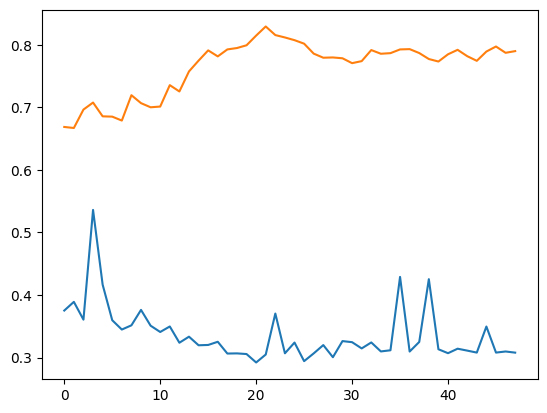

2/2 [==============================] - 0s 5ms/step
>49, d1=0.011, d2=0.621 d=0.316 g=0.792


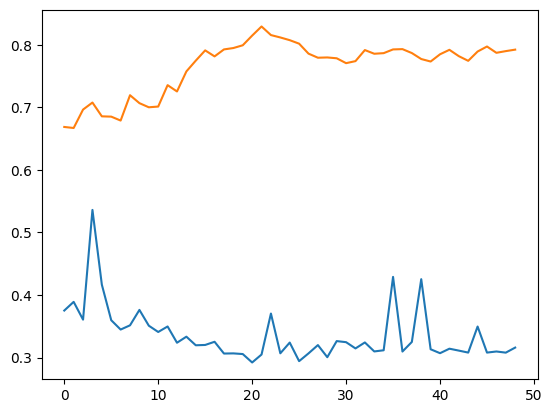

2/2 [==============================] - 0s 4ms/step
>50, d1=0.005, d2=0.615 d=0.310 g=0.795


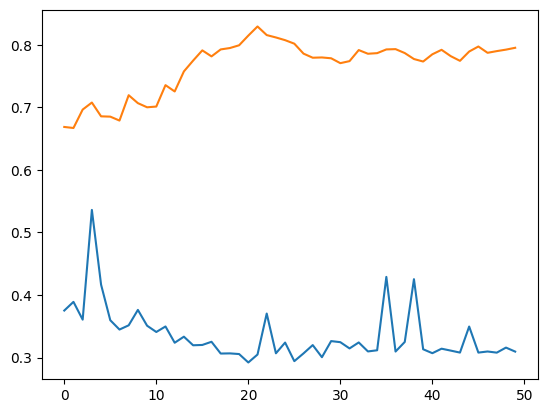

2/2 [==============================] - 0s 6ms/step
>51, d1=0.005, d2=0.599 d=0.302 g=0.795


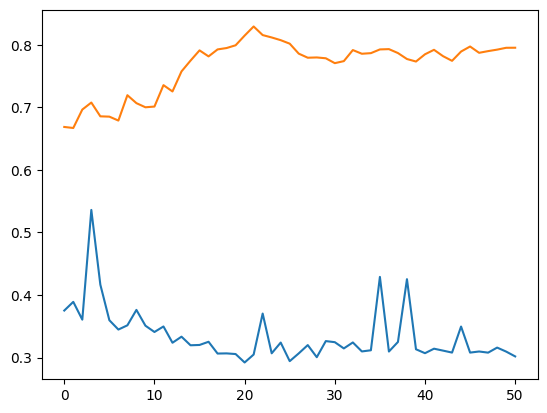

2/2 [==============================] - 0s 4ms/step
>52, d1=0.000, d2=0.605 d=0.302 g=0.812


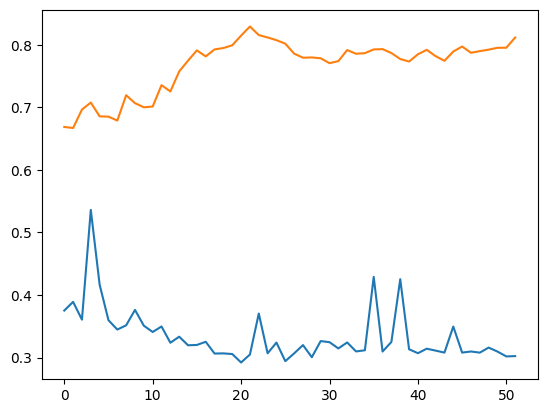

2/2 [==============================] - 0s 6ms/step
>53, d1=0.003, d2=0.605 d=0.304 g=0.816


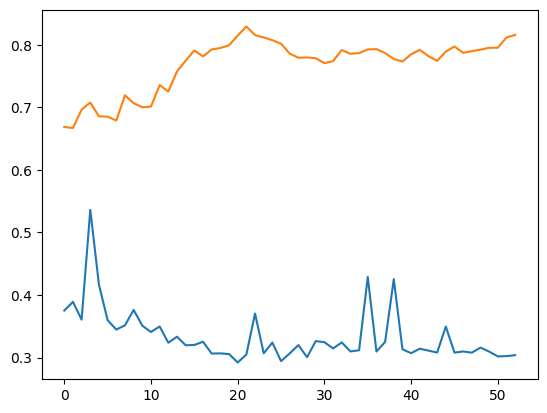

2/2 [==============================] - 0s 7ms/step
>54, d1=0.165, d2=0.597 d=0.381 g=0.803


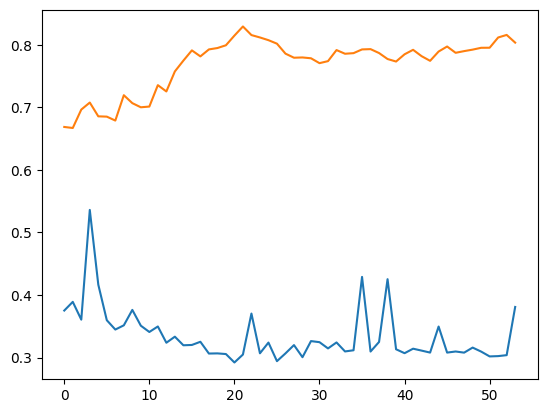

2/2 [==============================] - 0s 5ms/step
>55, d1=0.005, d2=0.603 d=0.304 g=0.810


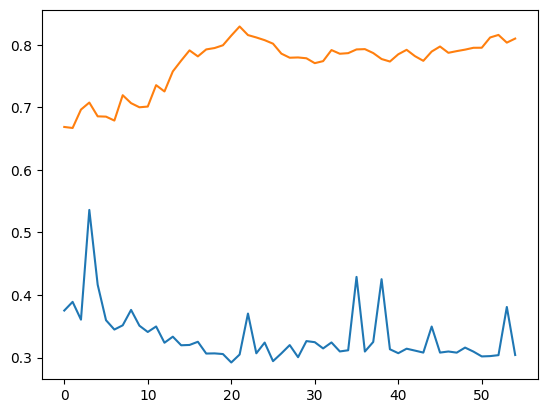

2/2 [==============================] - 0s 5ms/step
>56, d1=0.002, d2=0.614 d=0.308 g=0.811


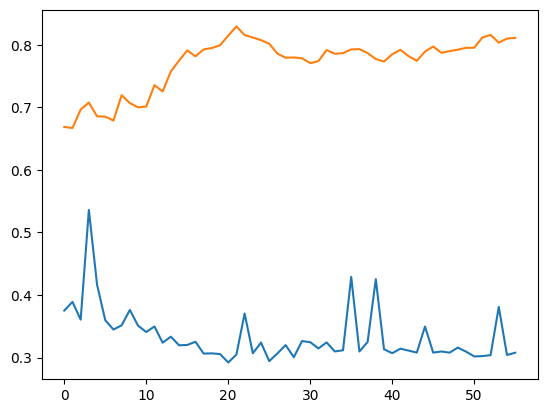

2/2 [==============================] - 0s 3ms/step
>57, d1=0.081, d2=0.610 d=0.346 g=0.816


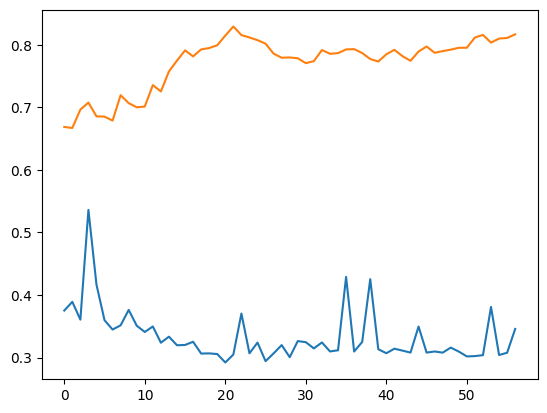

2/2 [==============================] - 0s 4ms/step
>58, d1=0.000, d2=0.605 d=0.302 g=0.801


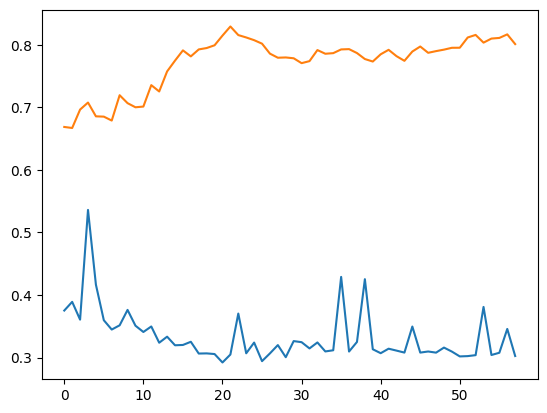

2/2 [==============================] - 0s 6ms/step
>59, d1=0.135, d2=0.608 d=0.372 g=0.806


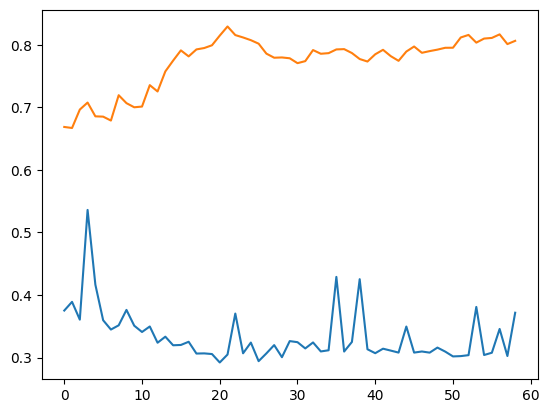

2/2 [==============================] - 0s 5ms/step
>60, d1=0.088, d2=0.602 d=0.345 g=0.810


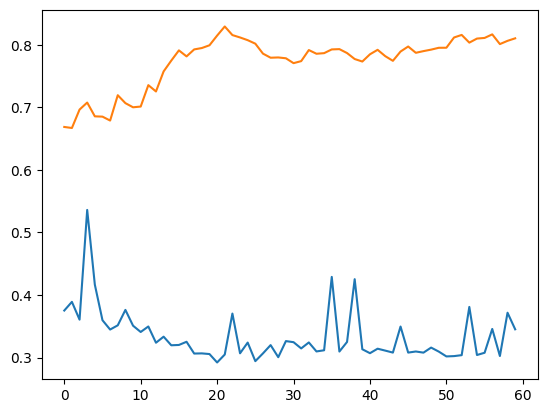

2/2 [==============================] - 0s 4ms/step
>61, d1=0.000, d2=0.606 d=0.303 g=0.806


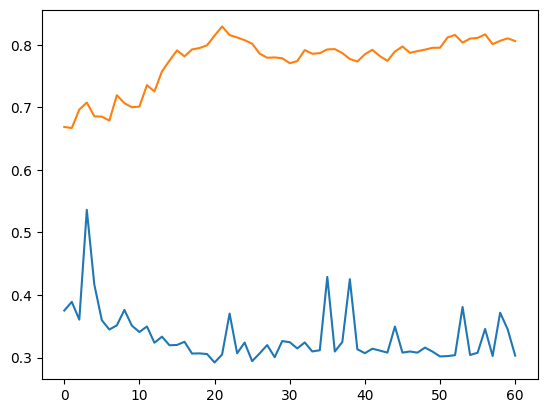

2/2 [==============================] - 0s 10ms/step
>62, d1=0.001, d2=0.607 d=0.304 g=0.808


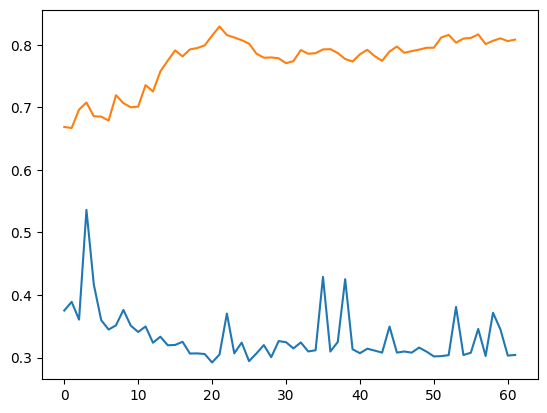

2/2 [==============================] - 0s 4ms/step
>63, d1=0.000, d2=0.590 d=0.295 g=0.823


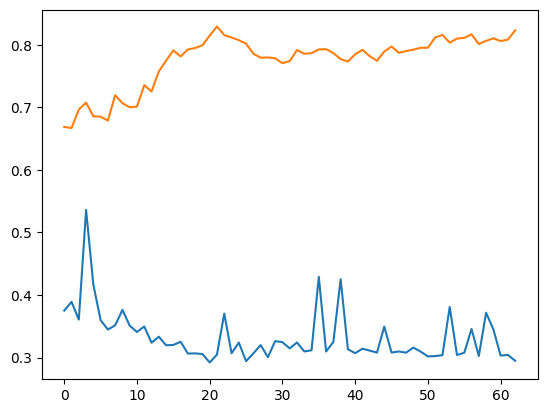

2/2 [==============================] - 0s 5ms/step
>64, d1=0.010, d2=0.590 d=0.300 g=0.837


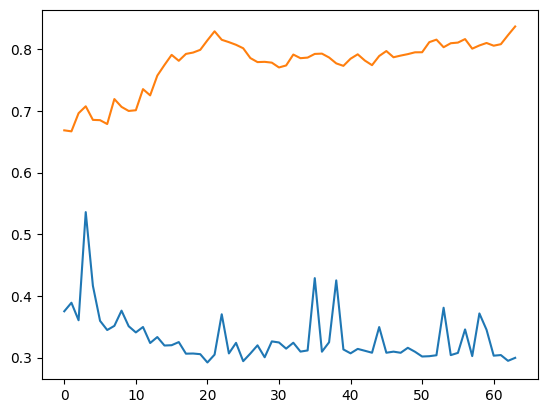

2/2 [==============================] - 0s 5ms/step
>65, d1=0.008, d2=0.580 d=0.294 g=0.854


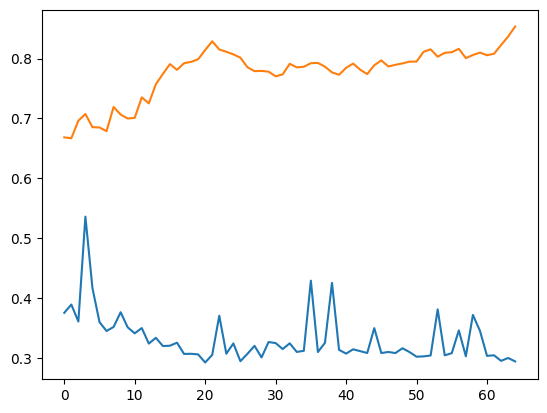

2/2 [==============================] - 0s 5ms/step
>66, d1=0.000, d2=0.560 d=0.280 g=0.844


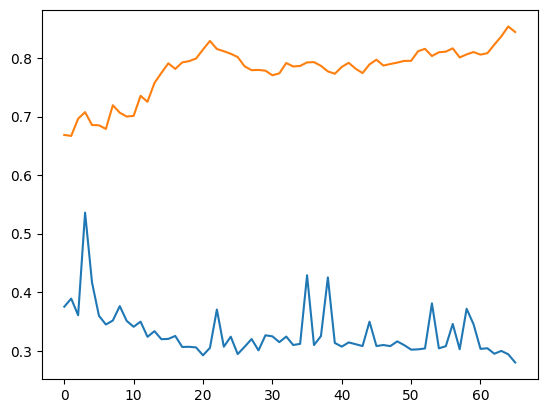

2/2 [==============================] - 0s 4ms/step
>67, d1=0.005, d2=0.571 d=0.288 g=0.864


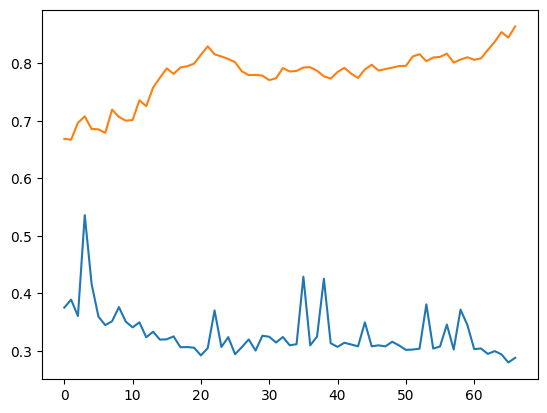

2/2 [==============================] - 0s 5ms/step
>68, d1=0.010, d2=0.557 d=0.284 g=0.877


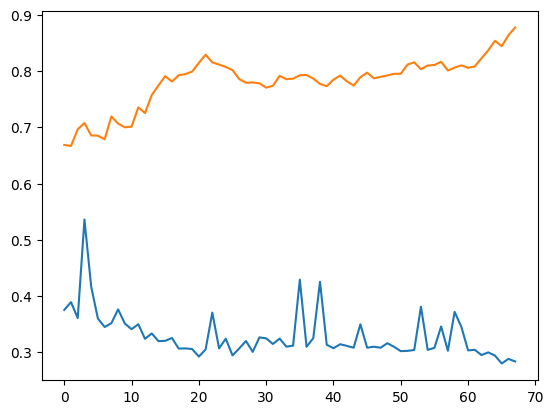

2/2 [==============================] - 0s 9ms/step
>69, d1=0.004, d2=0.536 d=0.270 g=0.874


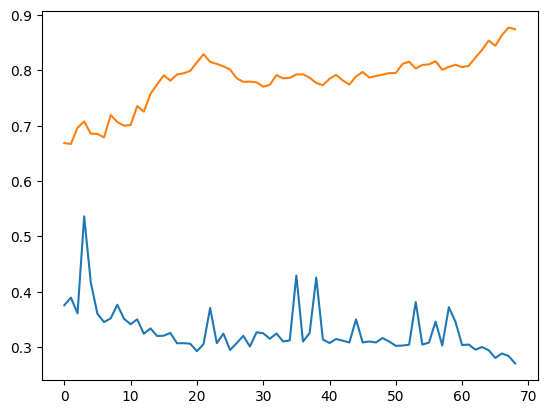

2/2 [==============================] - 0s 11ms/step
>70, d1=0.003, d2=0.535 d=0.269 g=0.893


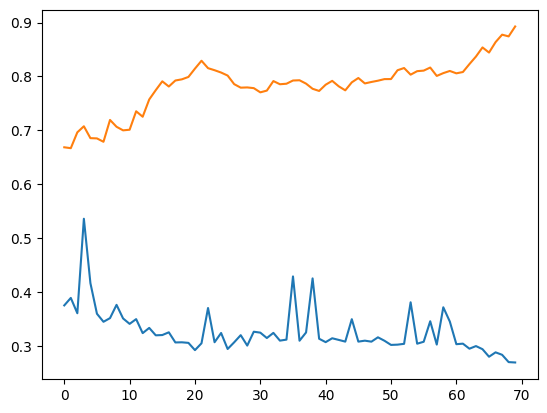

2/2 [==============================] - 0s 4ms/step
>71, d1=0.004, d2=0.537 d=0.271 g=0.898


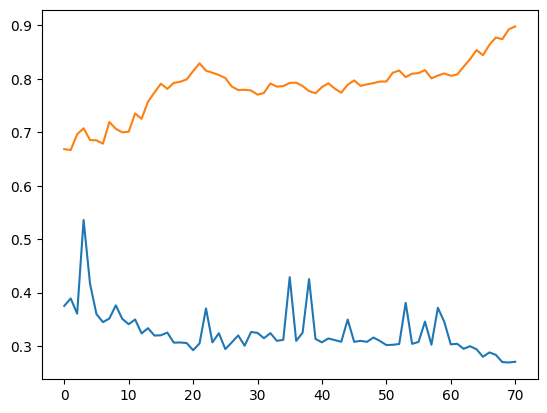

2/2 [==============================] - 0s 4ms/step
>72, d1=0.012, d2=0.541 d=0.276 g=0.899


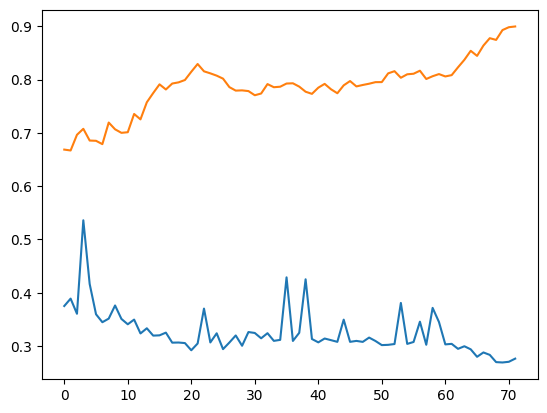

2/2 [==============================] - 0s 6ms/step
>73, d1=0.001, d2=0.524 d=0.262 g=0.917


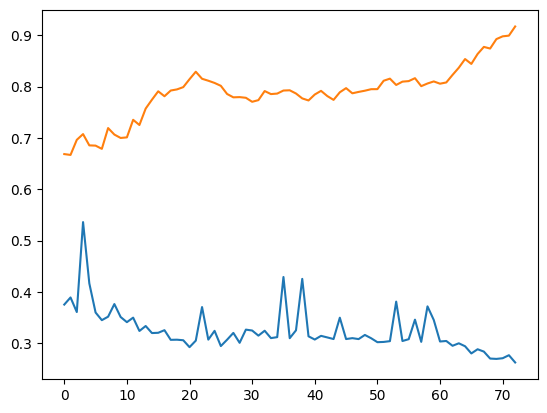

2/2 [==============================] - 0s 4ms/step
>74, d1=0.006, d2=0.505 d=0.255 g=0.957


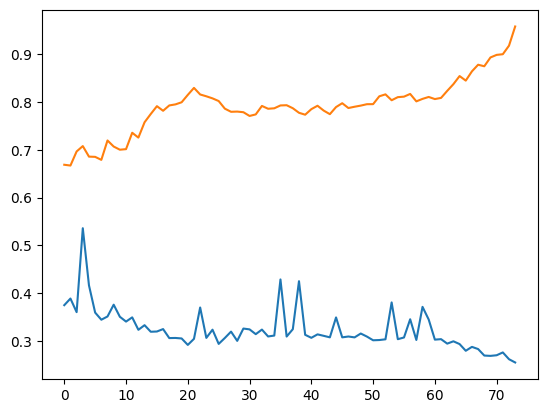

2/2 [==============================] - 0s 4ms/step
>75, d1=0.008, d2=0.502 d=0.255 g=0.951


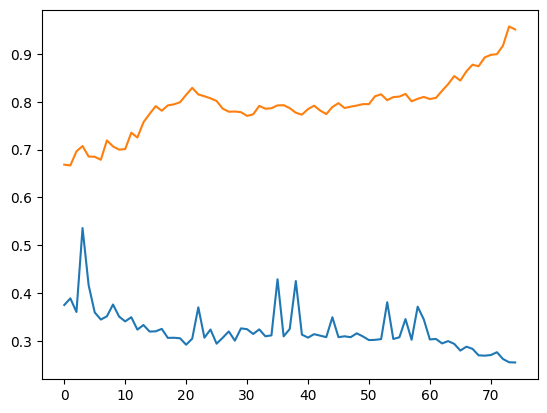

2/2 [==============================] - 0s 4ms/step
>76, d1=0.005, d2=0.496 d=0.251 g=0.998


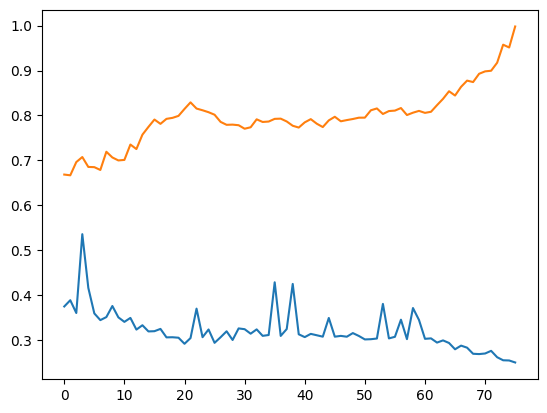

2/2 [==============================] - 0s 5ms/step
>77, d1=0.086, d2=0.497 d=0.292 g=0.998


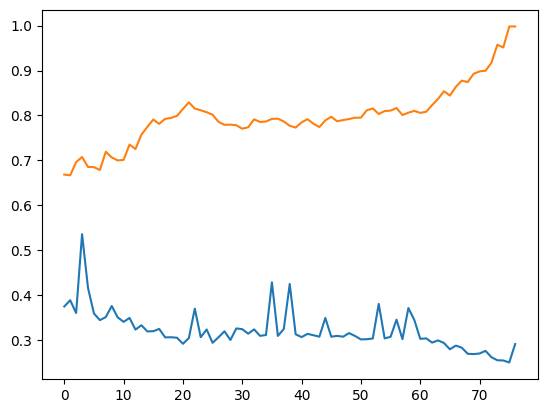

2/2 [==============================] - 0s 6ms/step
>78, d1=0.009, d2=0.477 d=0.243 g=0.986


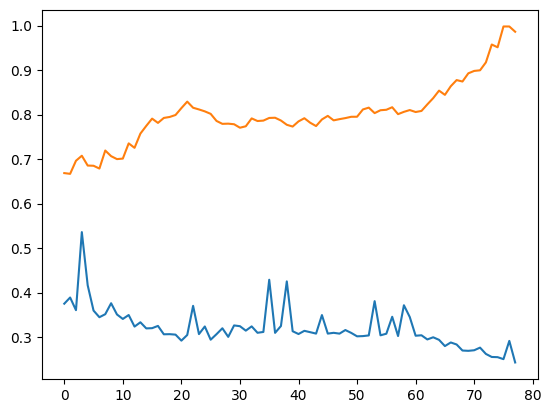

2/2 [==============================] - 0s 4ms/step
>79, d1=0.010, d2=0.485 d=0.247 g=0.997


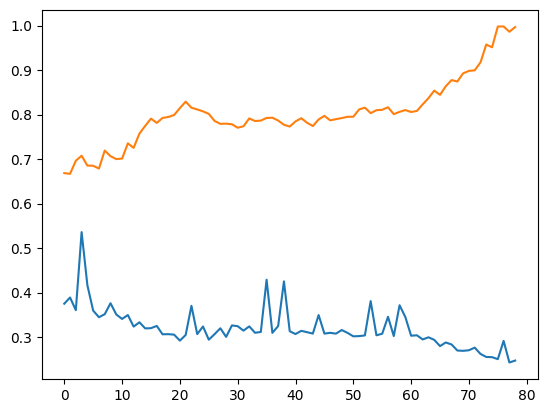

2/2 [==============================] - 0s 5ms/step
>80, d1=0.007, d2=0.466 d=0.236 g=1.017


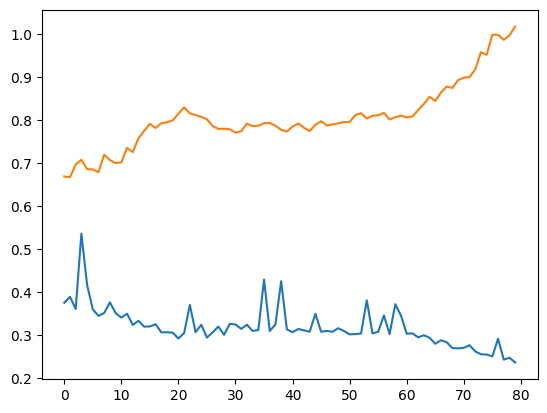

2/2 [==============================] - 0s 6ms/step
>81, d1=0.052, d2=0.456 d=0.254 g=1.002


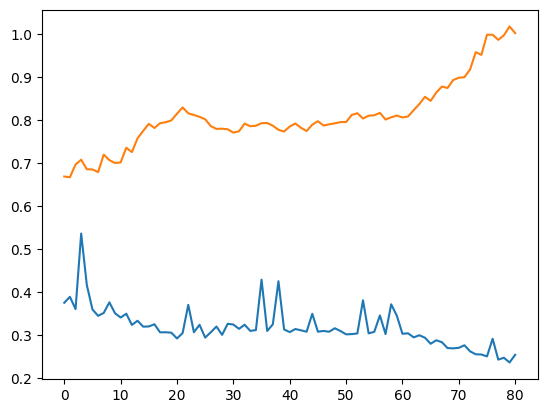

2/2 [==============================] - 0s 5ms/step
>82, d1=0.004, d2=0.481 d=0.242 g=0.997


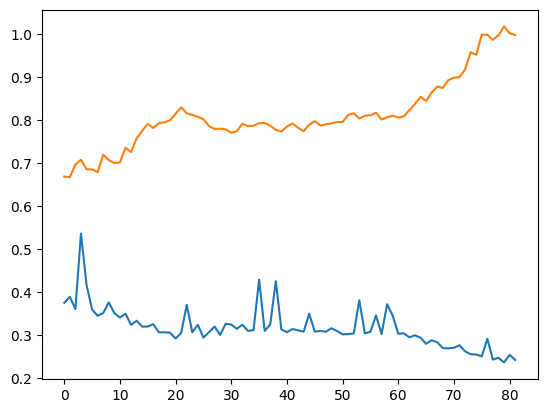

2/2 [==============================] - 0s 4ms/step
>83, d1=0.001, d2=0.506 d=0.254 g=0.997


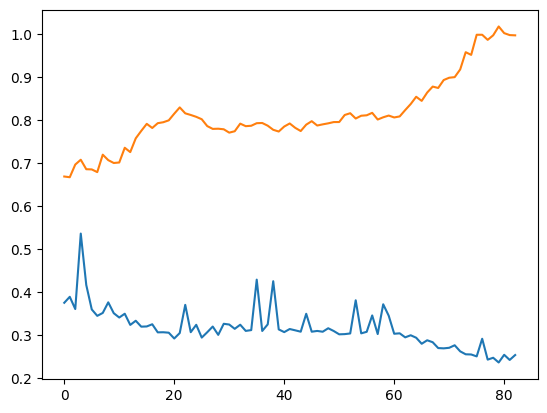

2/2 [==============================] - 0s 4ms/step
>84, d1=0.022, d2=0.490 d=0.256 g=1.024


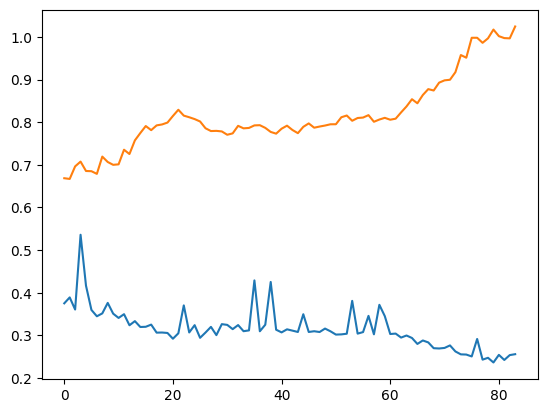

2/2 [==============================] - 0s 4ms/step
>85, d1=0.001, d2=0.481 d=0.241 g=1.001


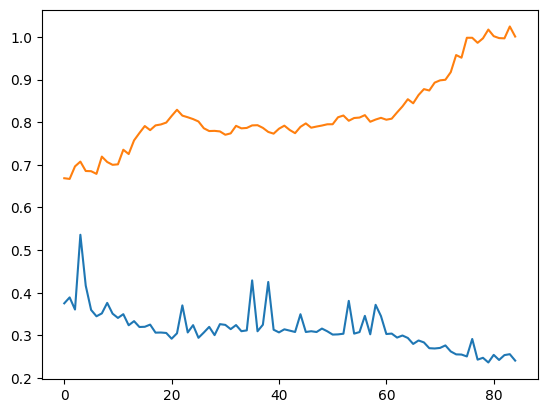

2/2 [==============================] - 0s 4ms/step
>86, d1=0.007, d2=0.448 d=0.228 g=1.019


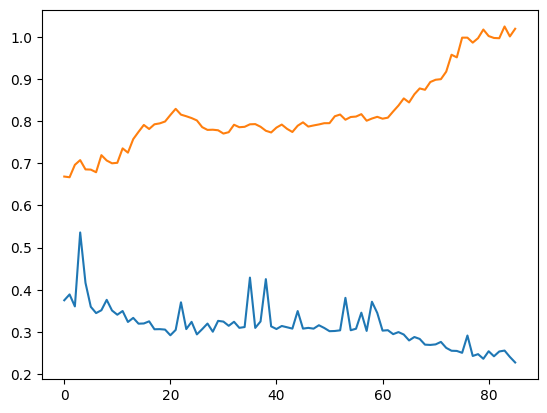

2/2 [==============================] - 0s 4ms/step
>87, d1=0.012, d2=0.448 d=0.230 g=1.021


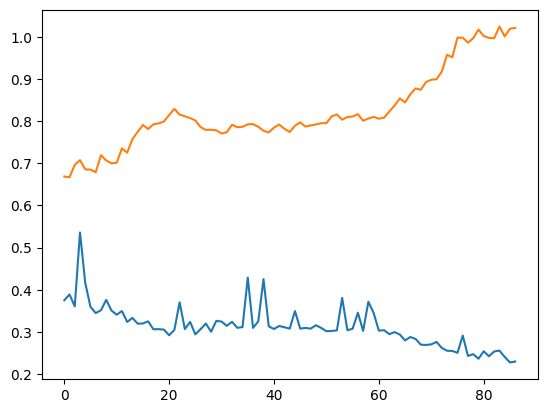

2/2 [==============================] - 0s 7ms/step
>88, d1=0.003, d2=0.478 d=0.240 g=1.032


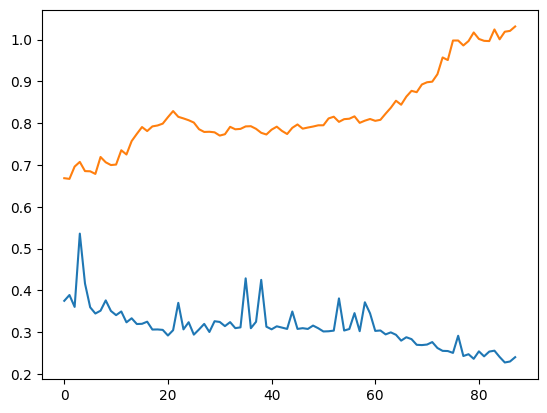

2/2 [==============================] - 0s 4ms/step
>89, d1=0.002, d2=0.481 d=0.242 g=1.048


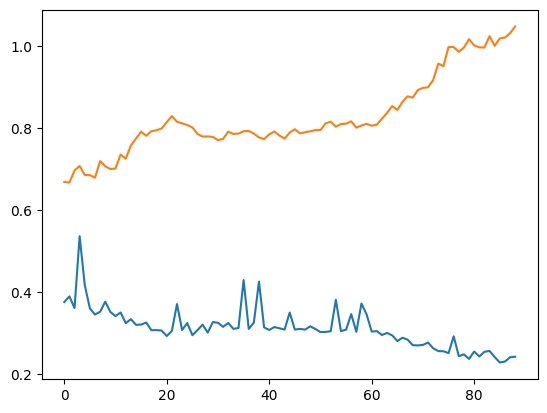

2/2 [==============================] - 0s 4ms/step
>90, d1=0.006, d2=0.444 d=0.225 g=1.047


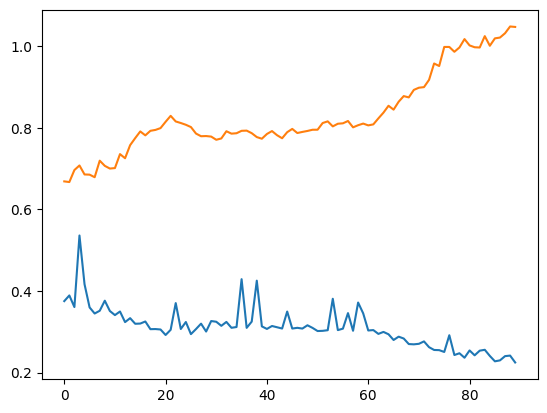

2/2 [==============================] - 0s 10ms/step
>91, d1=0.018, d2=0.439 d=0.229 g=1.057


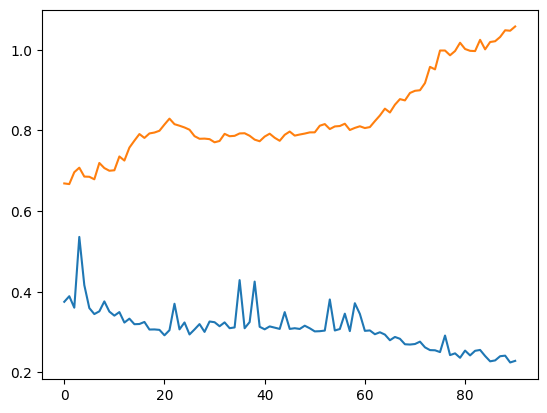

2/2 [==============================] - 0s 4ms/step
>92, d1=0.048, d2=0.441 d=0.244 g=1.028


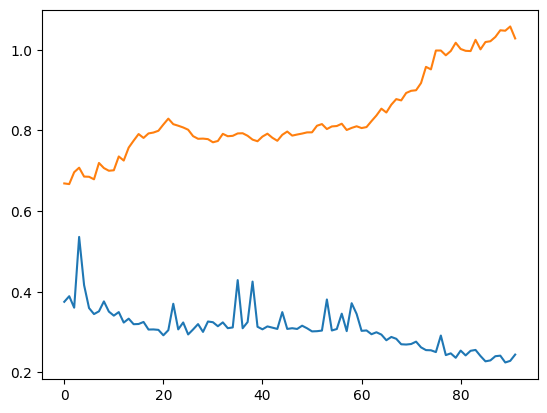

2/2 [==============================] - 0s 4ms/step
>93, d1=0.107, d2=0.485 d=0.296 g=0.994


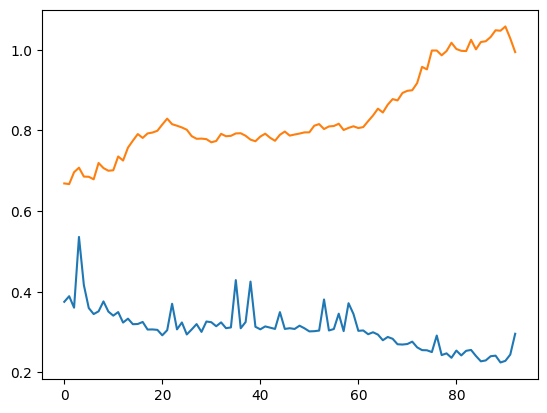

2/2 [==============================] - 0s 6ms/step
>94, d1=0.003, d2=0.454 d=0.229 g=1.016


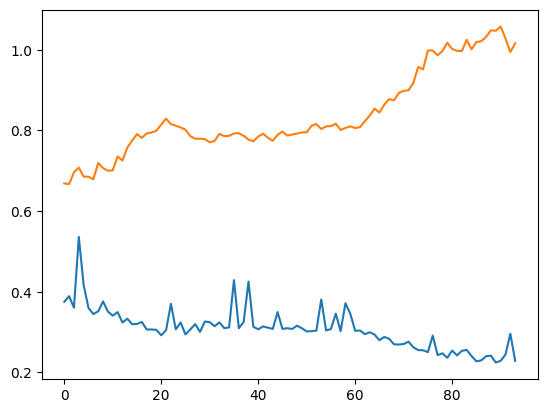

2/2 [==============================] - 0s 6ms/step
>95, d1=0.001, d2=0.494 d=0.247 g=1.001


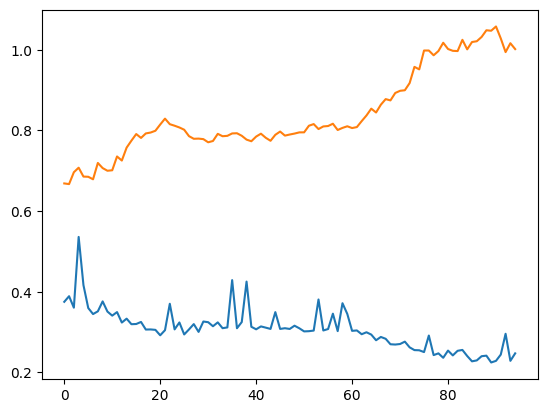

2/2 [==============================] - 0s 4ms/step
>96, d1=0.002, d2=0.476 d=0.239 g=1.004


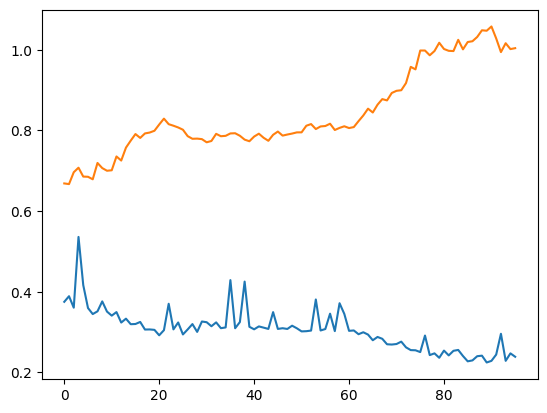

2/2 [==============================] - 0s 4ms/step
>97, d1=0.002, d2=0.452 d=0.227 g=1.024


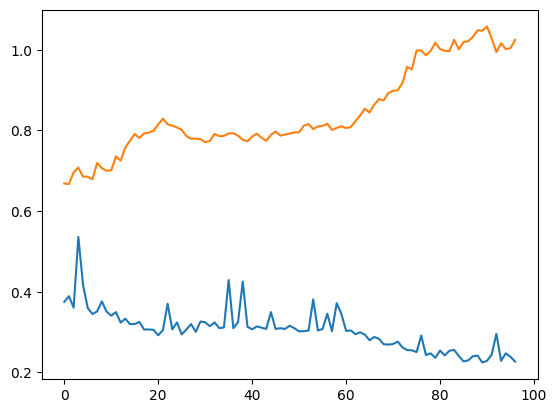

2/2 [==============================] - 0s 4ms/step
>98, d1=0.003, d2=0.441 d=0.222 g=1.070


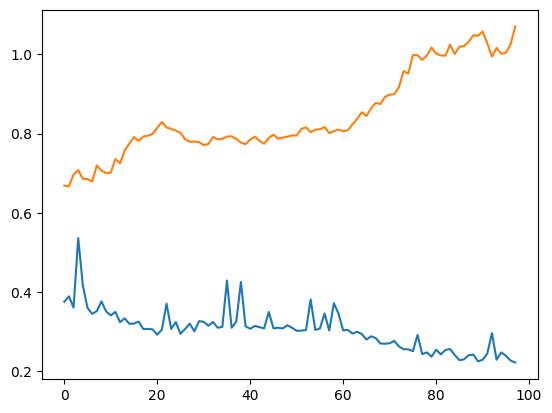

2/2 [==============================] - 0s 4ms/step
>99, d1=0.016, d2=0.445 d=0.230 g=1.064


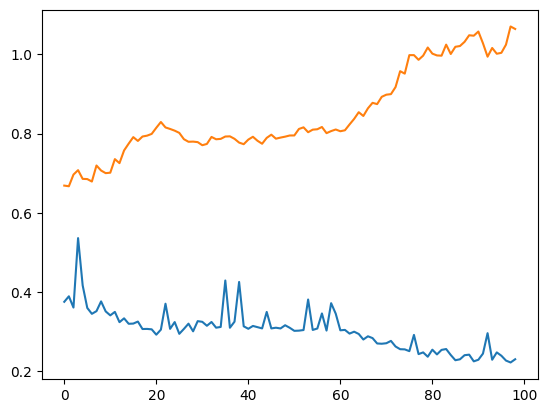

2/2 [==============================] - 0s 5ms/step
>100, d1=0.078, d2=0.427 d=0.252 g=1.045


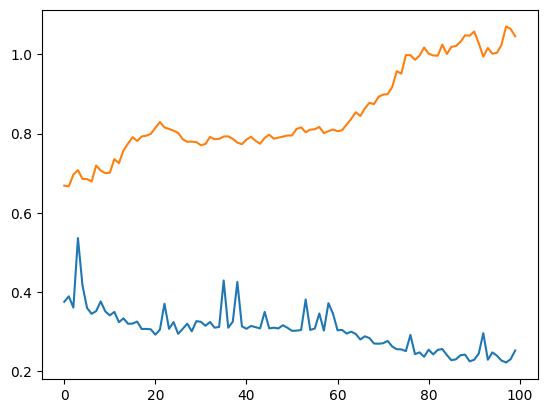

In [203]:
# size of the latent space
latent_dim = 10
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

In [204]:
from keras.models import load_model
model =load_model('trained_generated_model.h5')

In [211]:
latent_points = generate_latent_points(10, 750)
X = model.predict(latent_points)
data_fake = pd.DataFrame(data=X,  columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'])
data_fake.head()

24/24 [==============================] - 0s 2ms/step


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-1.3459,2.5622,3.6542,0.1586,1.2667,0.2709,-0.2865,0.1865,-1.2959
1,-0.6445,1.3025,1.2152,0.4648,-0.5119,1.3933,-0.3860,0.4285,-0.1471
2,-0.8050,1.8637,1.7680,0.3937,0.9318,0.5351,-0.6819,1.2463,-0.2893
3,-0.8667,1.6983,1.9879,-0.1209,0.2583,0.3424,0.3550,1.1695,-0.7903
4,-0.3181,1.9120,1.5582,0.8199,0.0355,1.0633,0.0744,0.9078,-0.5765


In [212]:
outcome_mean = data_fake.Outcome.mean()
data_fake['Outcome'] = data_fake['Outcome'] > outcome_mean
data_fake["Outcome"] = data_fake["Outcome"].astype(int)
print(data_fake['Outcome'])

0      0
1      1
2      1
3      0
4      0
      ..
745    1
746    1
747    0
748    1
749    0
Name: Outcome, Length: 750, dtype: int64


In [213]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
label = ['Outcome']
X_fake_created = data_fake[features]
y_fake_created = data_fake[label]

In [214]:
X_fake_train, X_fake_test, y_fake_train, y_fake_test = train_test_split(X_fake_created, y_fake_created, test_size=0.30, random_state=42)

In [220]:
## Random forest
clf_fake = RandomForestClassifier(n_estimators=500)
clf_fake.fit(X_fake_train,y_fake_train)
y_fake_pred=clf_fake.predict(X_fake_test)
print("Accuracy of fake data model:",metrics.accuracy_score(y_fake_test, y_fake_pred))

<ipython-input-220-c445c1529556>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_fake.fit(X_fake_train,y_fake_train)


Accuracy of fake data model: 0.7555555555555555


In [45]:
## Decision Tree
from sklearn.tree import DecisionTreeClassifier
dtree_fake = DecisionTreeClassifier()
dtree_fake.fit(X_fake_train, y_fake_train)
predictions_f = dtree_fake.predict(X_fake_test)
print("Accuracy Score =", format(metrics.accuracy_score(y_fake_test,predictions_f)))

Accuracy Score = 0.6755555555555556


In [46]:
## Support Vector Machine (SVM)
from sklearn.svm import SVC
svc_model_f = SVC()
svc_model_f.fit(X_fake_train, y_fake_train)
svc_pred_f = svc_model_f.predict(X_fake_test)
print("Accuracy Score =", format(metrics.accuracy_score(y_fake_test, svc_pred_f)))

Accuracy Score = 0.72


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# **Observation**:
1. **Batch size=128**, no change in discriminator and generator then **ACC=75.55%**
2. **Batch size=256**, no change in discriminator and generator then **ACC=85.28%**(base acc.=76.19)
3. Batch size=256, **dense layer added in discriminator** with **100 hidden nodes** and **relu as an activation fn** and no change in generator then **ACC=79.8%**
4. Same as 3 but **one more dense layer** with **150 hidden nodes** and **relu** as act. fn is added in discriminator then **Acc=81.3%**
5. **same as 3** but **reduced batch size to 128** then **Acc= 72.72%**
6. **same as 5** but **added 2 dense layers with 45 and 65 hidden nodes** respectively and **relu** as an act. fn in **generator** then **Acc shoots up to 97.8%**